


<a target="_blank" href="https://colab.research.google.com/github/jgomelop/ai4eng_CusFraDect/blob/master/1%20-%20Exploraci%C3%B3n%20de%20datos%20TRAIN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>




# Introducción

**Objetivo**: Predecir la probabilidad de que una transacción en línea sea clasificada como fraudulenta.

DE acuerdo con la [esta discusión](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284), es mejor predecir clientes fraudulentos (sus tarjetas de crédito) en lugar de las transacciones como tal.

Tenemos dos datasets: uno para la transacciones y otro para la identidad de lso clientes.

Nota: "Not all transactions have corresponding identity information."

Categorical Features - Transaction

* ProductCD
* emaildomain
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Categorical Features - Identity

* DeviceType
* DeviceInfo
* id_12 - id_38

"The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp)."

Para esta exploración, tomaremos como referencias [esta](https://www.kaggle.com/code/robikscube/ieee-fraud-detection-first-look-and-eda/notebook#Train-vs-Test-are-Time-Series-Split) y [esta](https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook#Target-Distribution) discusiones.

In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=1H0OEYX33Qj-ggnlic0ILN3tcwIRbGATt

Downloading...
From: https://drive.google.com/uc?id=1H0OEYX33Qj-ggnlic0ILN3tcwIRbGATt
To: /content/ieee-fraud-detection.zip
100% 124M/124M [00:01<00:00, 98.8MB/s]


In [3]:
!mkdir data
!unzip ieee-fraud-detection.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  ieee-fraud-detection.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
!rm -r sample_data/

rm: cannot remove 'sample_data/': No such file or directory


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
  """
  From https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook

  """
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df
  

In [7]:
def resumetable(df):
  """
  Adaptado de:
  https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook#Competition-Objective-is-to-detect-fraud-in-transactions;


  """
  print(f"Dataset Shape: {df.shape}")
  summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
  summary = summary.reset_index()
  summary['Nombre'] = summary['index']
  summary = summary[['Nombre','dtypes']]
  summary['% NaN'] = df.isnull().sum().values/len(df)*100    
  summary['Unique'] = df.nunique().values
  summary['Primer Valor'] = df.loc[0].values
  summary['Segundo Valor'] = df.loc[1].values
  summary['Tercer Valor'] = df.loc[2].values
  
  return summary

# Importado de datos

In [8]:
df_trans = pd.read_csv("data/train_transaction.csv")
df_trans = reduce_mem_usage(df_trans)
df_trans.head()

Mem. usage decreased to 542.35 Mb (69.4% reduction)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_id = pd.read_csv("data/train_identity.csv")
df_id = reduce_mem_usage(df_id)
df_id.head()

Mem. usage decreased to 25.86 Mb (42.7% reduction)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
#test_transaction = pd.read_csv('data/test_transaction.csv')
#test_transaction = reduce_mem_usage(test_transaction)
#test_transaction.head()

In [11]:
#test_id = pd.read_csv('data/test_transaction.csv')
#test_id = reduce_mem_usage(test_id)
#test_id.head()

# Exploración

## Transaction data

In [12]:
# Correspondencia entre tabla de transacciones e identidad.
x = np.sum(df_trans['TransactionID'].isin(df_id['TransactionID'].unique()))
print(f"# transacciones: {x}")

# transacciones: 144233


Solo 144233 transacciones tienen asociado almenos un registro en la tabla identidad. "Not all transactions have corresponding identity information."

In [13]:
trans_resume = resumetable(df_trans)

Dataset Shape: (590540, 394)


In [14]:
trans_resume.head()

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
0,TransactionID,int32,0.0,590540,2987000,2987001,2987002
1,isFraud,int8,0.0,2,0,0,0
2,TransactionDT,int32,0.0,573349,86400,86401,86469
3,TransactionAmt,float16,0.0,8195,68.5,29.0,59.0
4,ProductCD,object,0.0,5,W,W,W


Tenemos en total 590540 muestras con 394 características.

card1 - card6: payment card information, such as card type, card category,  issue bank, country, etc.

In [15]:
trans_resume.loc[(trans_resume.Nombre.str.contains("card"))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
5,card1,int16,0.000000,13553,13926,2755,4663
6,card2,float16,1.512683,500,NaN,404.0,490.0
7,card3,float16,0.265012,114,150.0,150.0,150.0
8,card4,object,0.267044,4,discover,mastercard,visa
9,card5,float16,0.721204,119,142.0,102.0,166.0
10,card6,object,0.266028,4,credit,credit,debit


dist: distance

In [16]:
trans_resume.loc[(trans_resume.Nombre.str.contains("dist"))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
13,dist1,float16,59.652352,2412,19.0,NaN,287.0
14,dist2,float16,93.628374,1699,NaN,NaN,NaN




"C1-C14: counting, such as how many addresses are found to be associated with * the payment card, etc. The actual meaning is masked."

In [17]:
trans_resume.loc[(trans_resume.Nombre.str.contains("C"))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
4,ProductCD,object,0.0,5,W,W,W
17,C1,float16,0.0,1495,1.0,1.0,1.0
18,C2,float16,0.0,1167,1.0,1.0,1.0
19,C3,float16,0.0,27,0.0,0.0,0.0
20,C4,float16,0.0,1223,0.0,0.0,0.0
21,C5,float16,0.0,319,0.0,0.0,0.0
22,C6,float16,0.0,1291,1.0,1.0,1.0
23,C7,float16,0.0,1069,0.0,0.0,0.0
24,C8,float16,0.0,1130,0.0,0.0,0.0
25,C9,float16,0.0,205,1.0,0.0,1.0


D1-D15: timedelta, such as days between previous transaction, etc.


In [18]:
trans_resume.loc[(trans_resume.Nombre.str.contains("D\d", regex = True))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
31,D1,float16,0.214888,641,14.0,0.0,0.0
32,D2,float16,47.549192,641,NaN,NaN,NaN
33,D3,float16,44.514851,649,13.0,NaN,NaN
34,D4,float16,28.604667,808,NaN,0.0,0.0
35,D5,float16,52.467403,688,NaN,NaN,NaN
36,D6,float16,87.606767,829,NaN,NaN,NaN
37,D7,float16,93.409930,597,NaN,NaN,NaN
38,D8,float16,87.312290,5367,NaN,NaN,NaN
39,D9,float16,87.312290,24,NaN,NaN,NaN
40,D10,float16,12.873302,818,13.0,0.0,0.0


M1-M9: match, such as names on card and address, etc.

In [19]:
trans_resume.loc[(trans_resume.Nombre.str.contains("M\d", regex = True))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
46,M1,object,45.907136,2,T,NaN,T
47,M2,object,45.907136,2,T,NaN,T
48,M3,object,45.907136,2,T,NaN,T
49,M4,object,47.658753,3,M2,M0,M0
50,M5,object,59.349409,2,F,T,F
51,M6,object,28.678836,2,T,T,F
52,M7,object,58.635317,2,NaN,NaN,F
53,M8,object,58.633115,2,NaN,NaN,F
54,M9,object,58.633115,2,NaN,NaN,F


Vxxx: Vesta engineered rich features, including ranking, counting, and other  entity relations.

In [20]:
trans_resume.loc[(trans_resume.Nombre.str.contains("V\d", regex = True))]

,Nombre,dtypes,% NaN,Unique,Primer Valor,Segundo Valor,Tercer Valor
55,V1,float16,47.293494,2,1.0,NaN,1.0
56,V2,float16,47.293494,9,1.0,NaN,1.0
57,V3,float16,47.293494,10,1.0,NaN,1.0
58,V4,float16,47.293494,7,1.0,NaN,1.0
59,V5,float16,47.293494,7,1.0,NaN,1.0
...,...,...,...,...,...,...,...
389,V335,float16,86.054967,669,NaN,NaN,NaN
390,V336,float16,86.054967,355,NaN,NaN,NaN
391,V337,float32,86.054967,254,NaN,NaN,NaN
392,V338,float32,86.054967,380,NaN,NaN,NaN


In [21]:
trans_resume.loc[(trans_resume.Nombre.str.contains("V\d", regex = True))]["dtypes"].value_counts()

float16    295
float32     44
Name: dtypes, dtype: int64

In [22]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [23]:
v_cols = [c for c in df_trans if c[0] == 'V']
df_trans['v_mean'] = df_trans[v_cols].mean(axis=1)


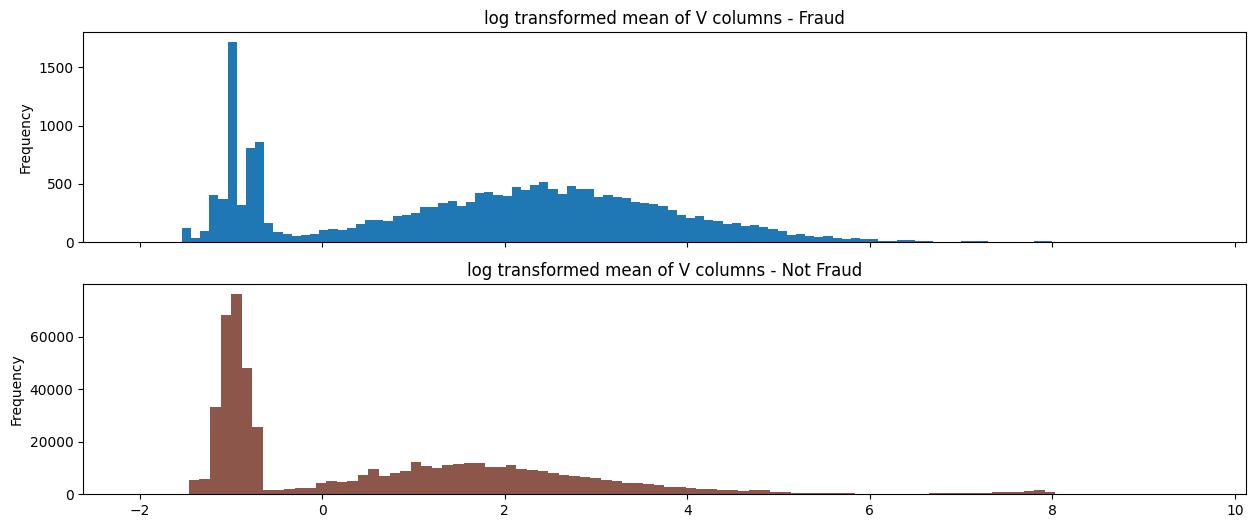

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
df_trans.loc[df_trans['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
df_trans.loc[df_trans['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

3.50% de transacciones son fraude en tabla de transacciones.


<Axes: xlabel='isFraud', ylabel='count'>

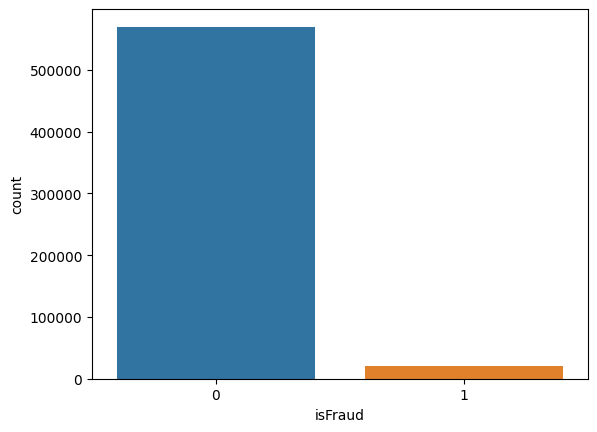

In [25]:
print('{:.2f}% de transacciones son fraude en tabla de transacciones.'.format(df_trans['isFraud'].mean() * 100))
sns.countplot(x=df_trans["isFraud"])

OBservamos un notable desbalance en la variable objetivo.

# Tabla identity

In [26]:
# Add the `isFraud` column for analysis
df_id_ = df_id.merge(df_trans[['TransactionID',
                                'TransactionDT',
                                'isFraud']],
                                on=['TransactionID'])


<ipython-input-27-85f4c81f56c7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_id_.groupby('DeviceType') \


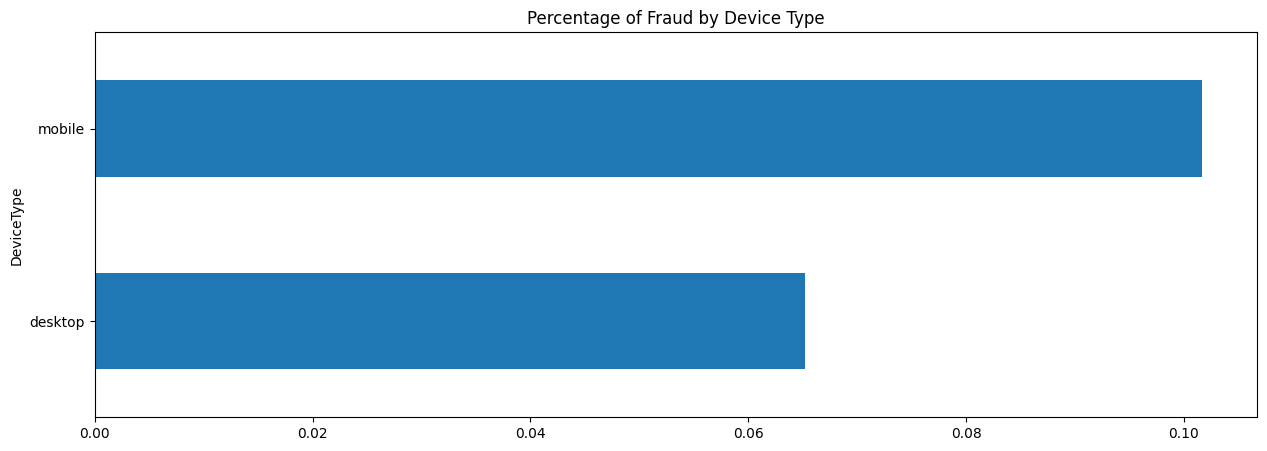

In [27]:
df_id_.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

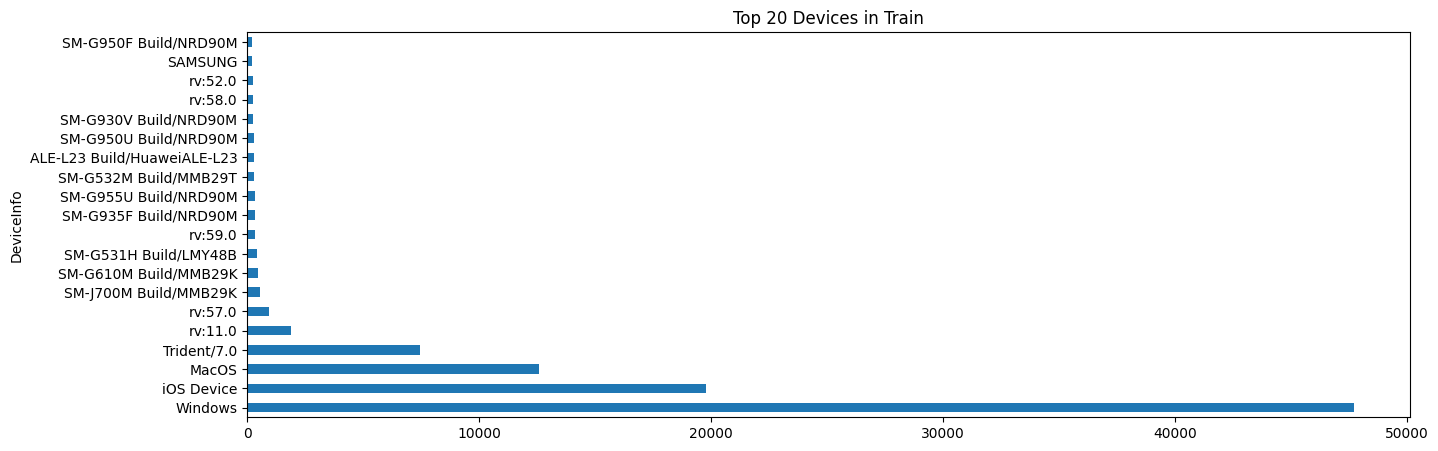

In [28]:
df_id_.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

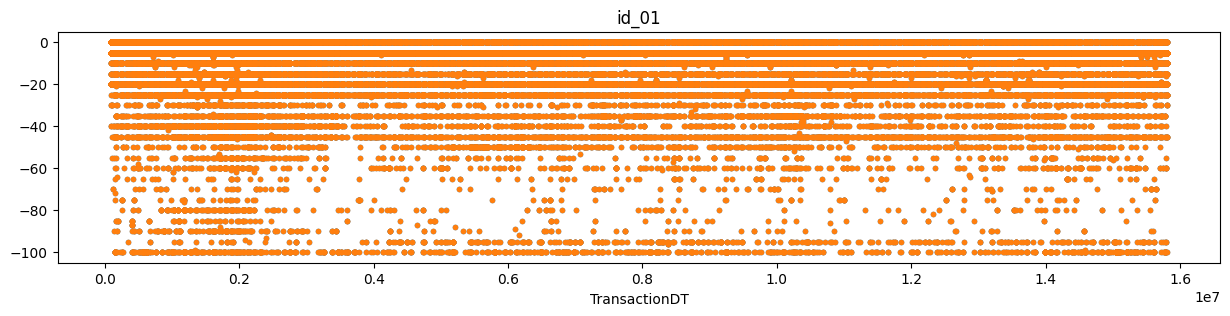

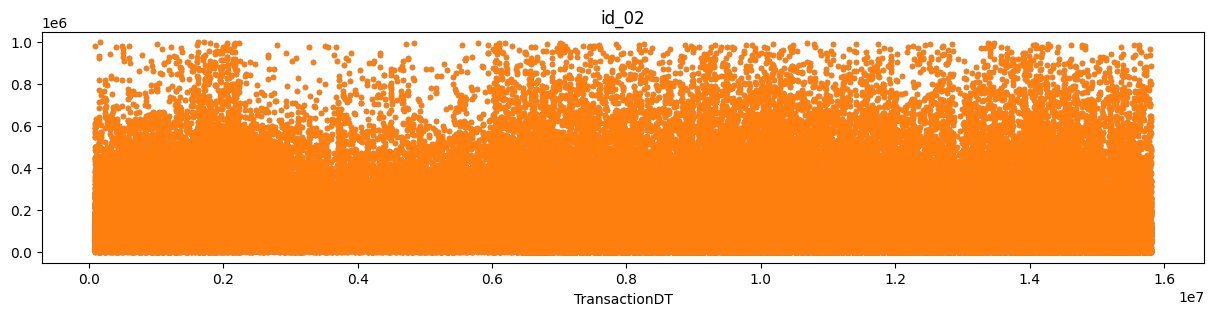

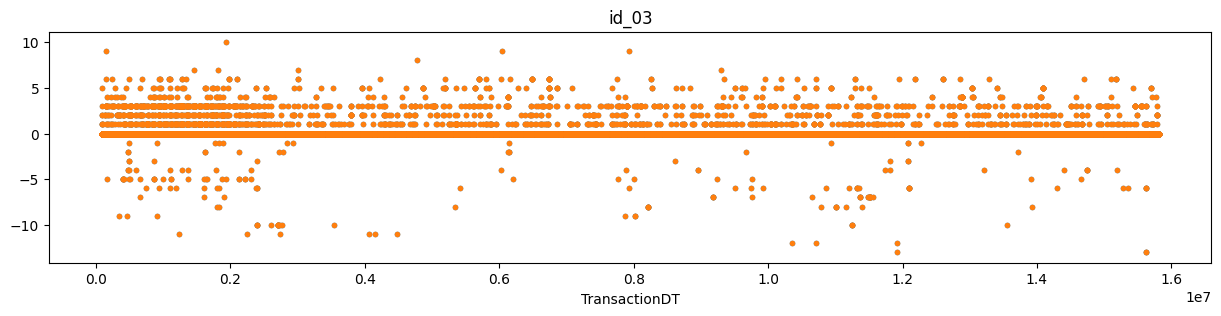

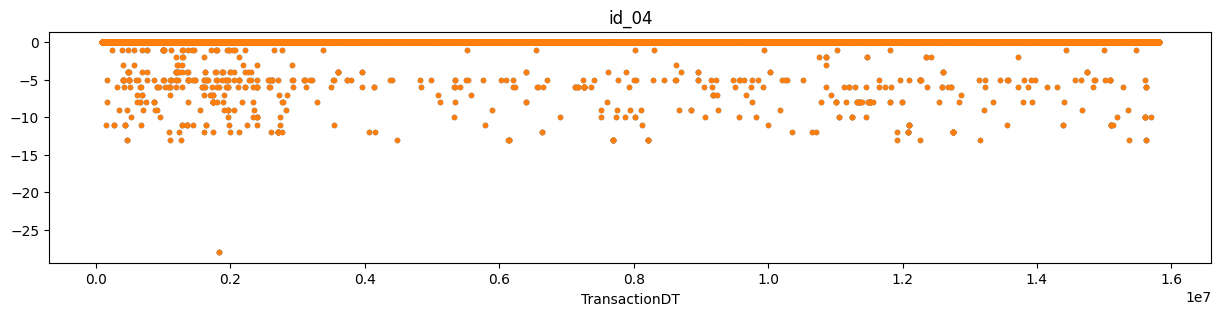

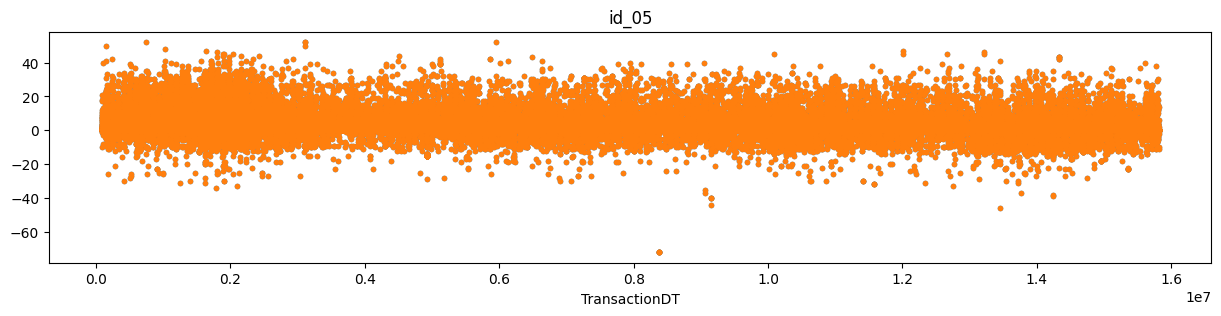

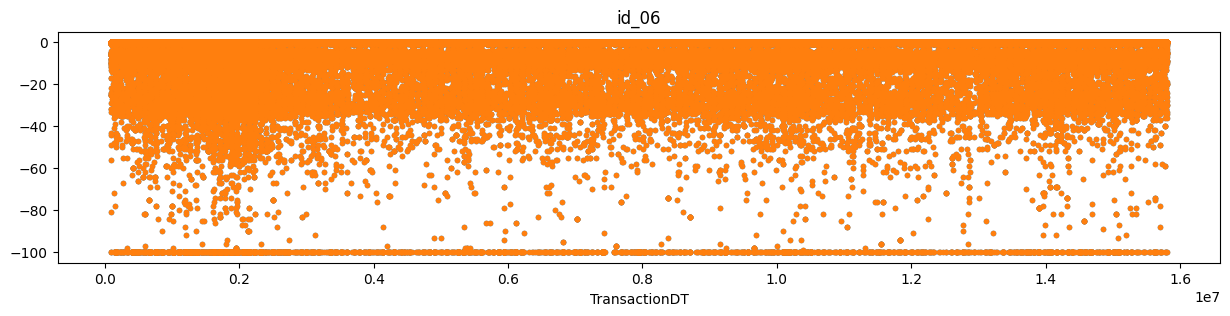

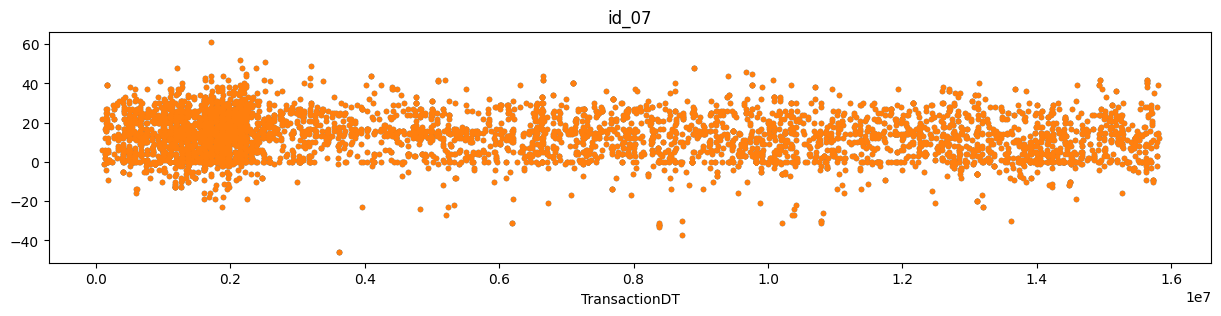

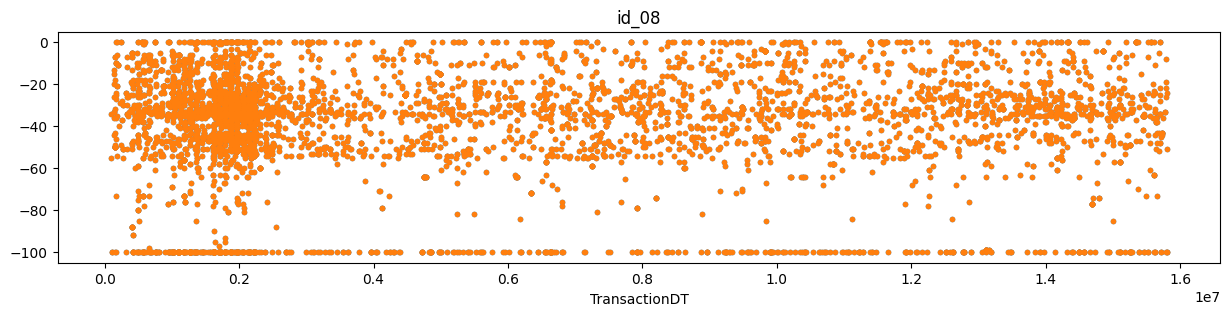

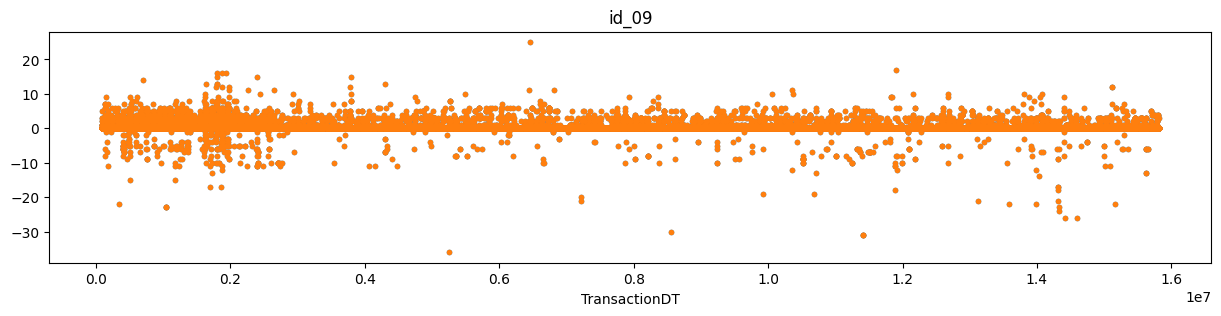

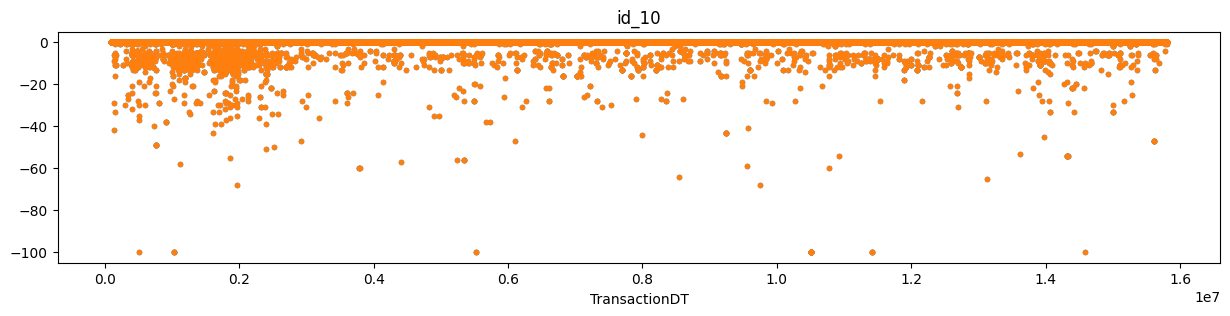

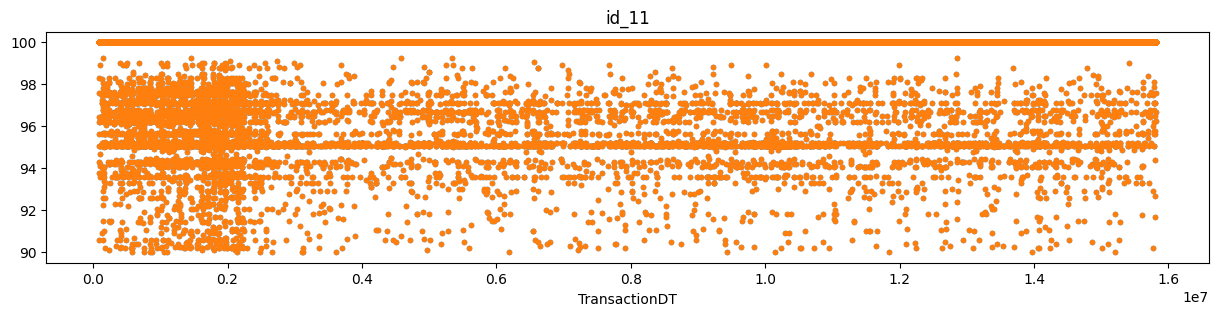

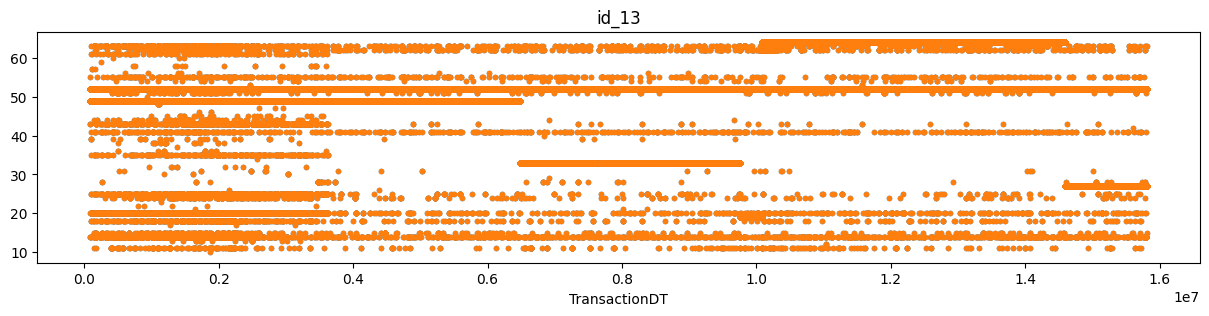

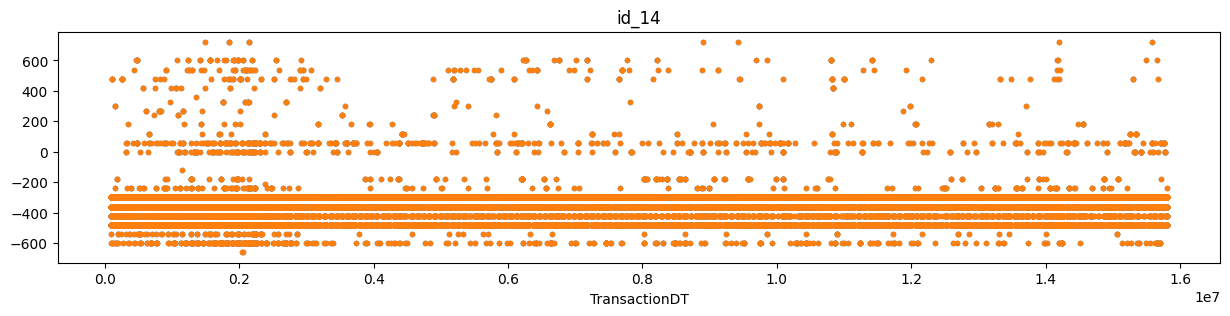

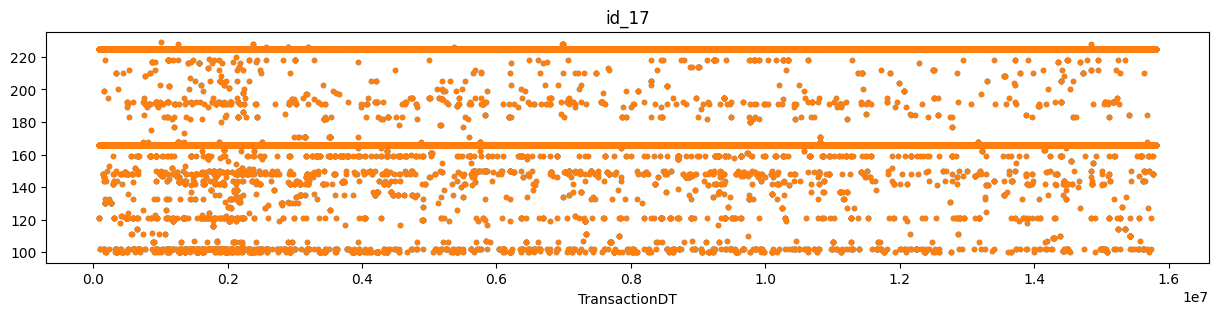

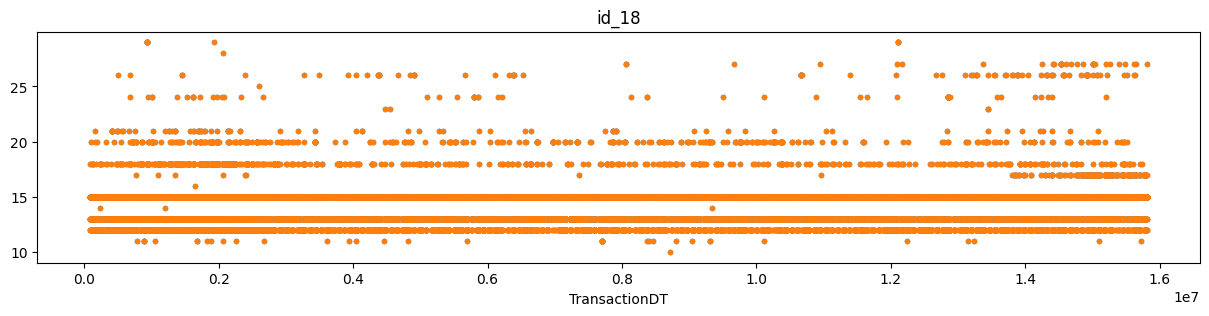

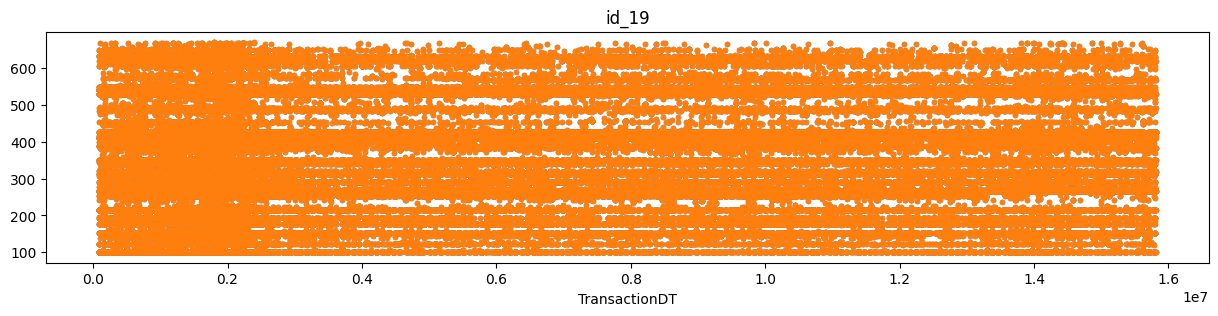

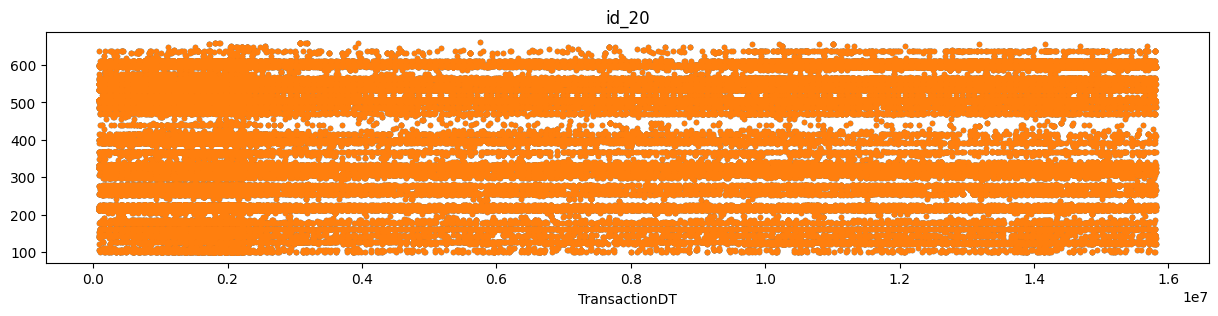

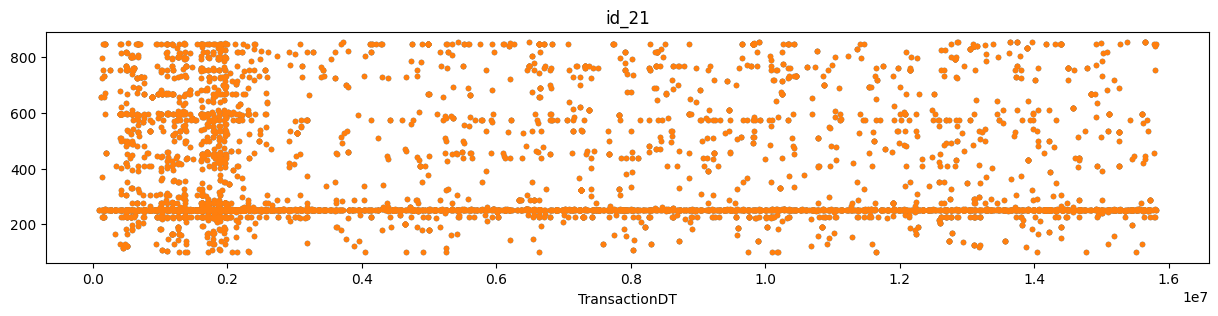

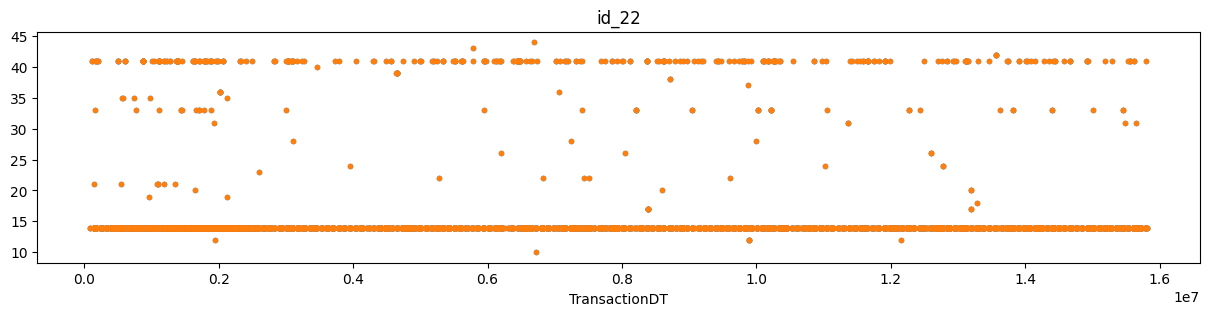

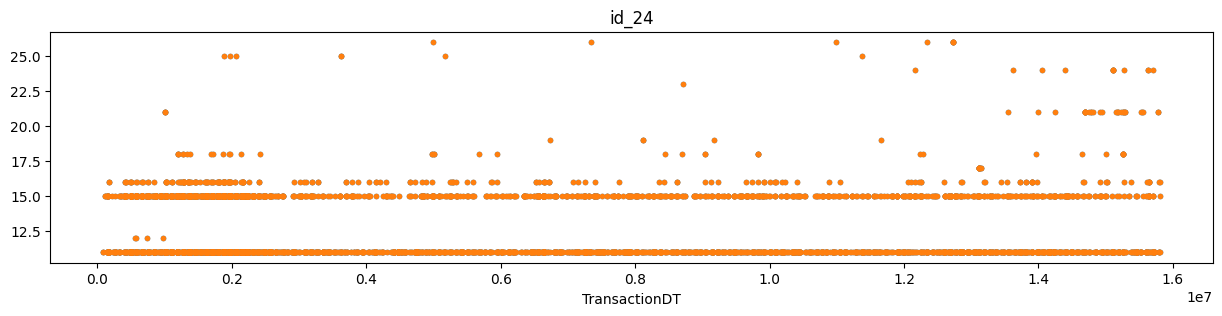

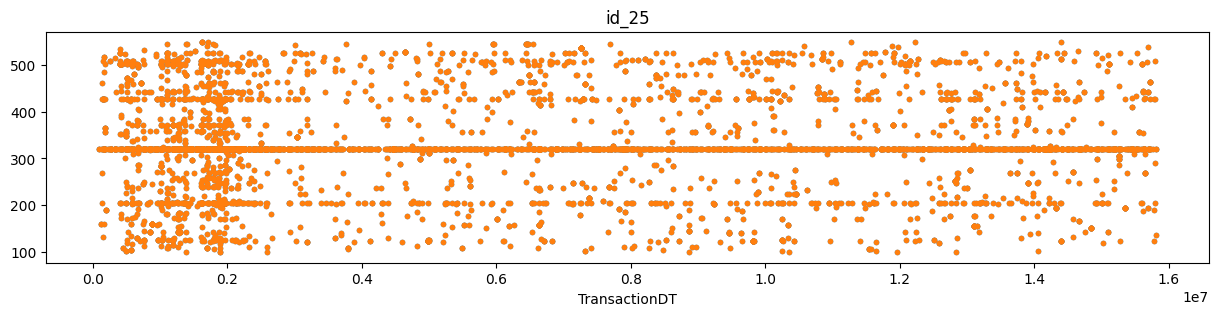

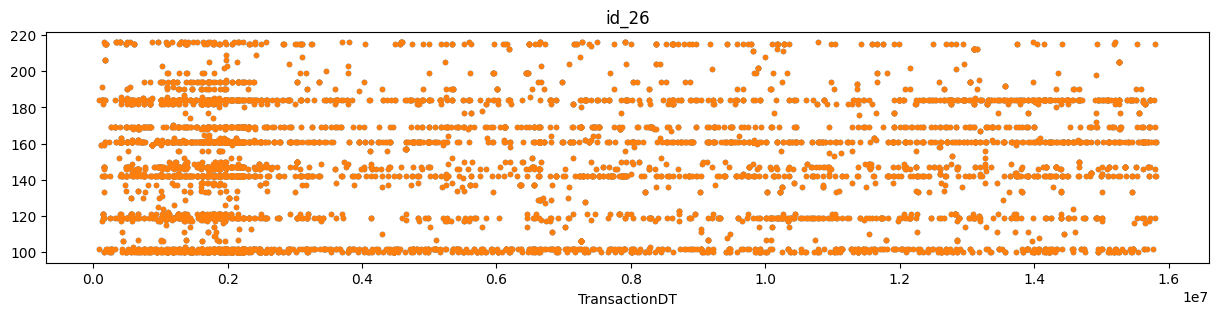

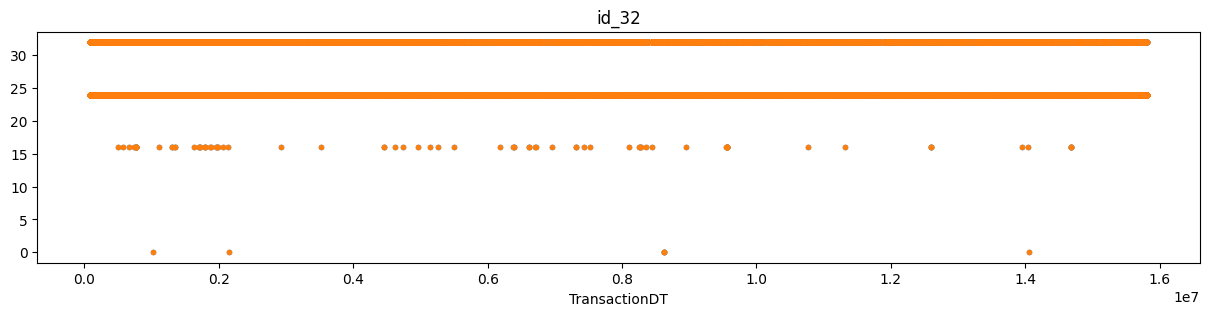

In [29]:
id_cols = [c for c in df_id.columns if 'id' in c]
for i in id_cols:
    try:
        df_id_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        df_id_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

# Discusiones de apoyo

https://www.kaggle.com/code/artgor/eda-and-models/notebook

https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook

https://www.kaggle.com/code/robikscube/ieee-fraud-detection-first-look-and-eda/notebook

https://www.kaggle.com/code/shahules/tackling-class-imbalance/notebook

https://www.kaggle.com/code/alijs1/ieee-transaction-columns-reference/notebook




